# Indices Secundarios en Riak

El objetivo es tener poder recuperar una lista de valores, sin conocer de ante mano la clave del registro.

Sería algo asi como:

```{sql}
select *
from bucket
where campo = valor
```

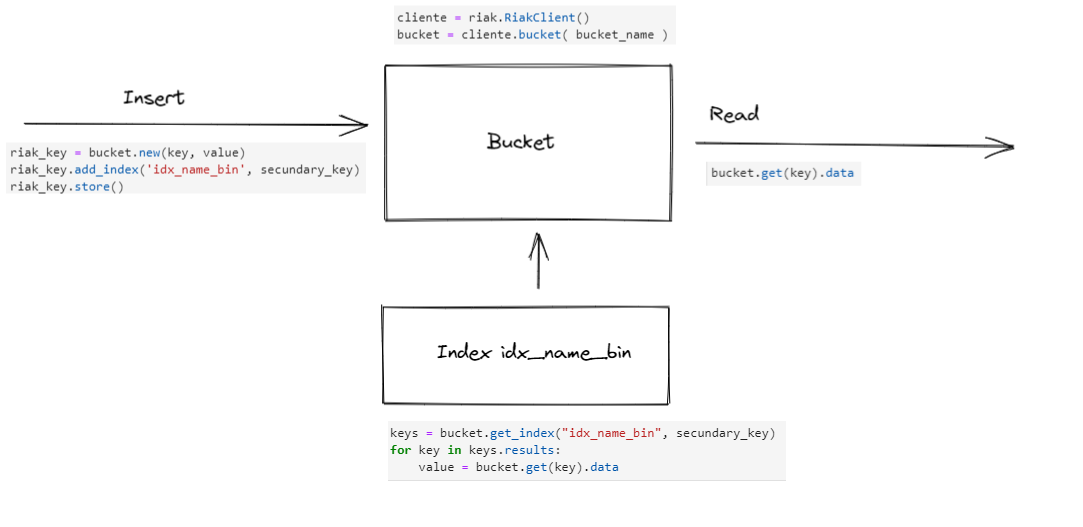## Conexión a Riak

### Conexión a Riak

In [ ]:
import riak

In [ ]:
cliente = riak.RiakClient()
print("¿Está Riak disponible?", cliente.ping())

## Escritura en Riak

Vamos a crear un dataset de datos ficticio y lo vamos a cargar en un dataframe de Pandas

In [ ]:
from faker import Faker
import pandas as pd
import json

faker = Faker()
Faker.seed(4321)
profiles = []
for i in range(10):
    profile = faker.simple_profile()
    profile['birthdate'] = profile['birthdate'].isoformat()
    profiles.append(profile) 

dataframe = pd.read_json(json.dumps(profiles, default=str))

In [ ]:
dataframe

Cada una de las filas del dataset es JSON (diccionario en Python)

In [ ]:
profiles[0]

In [ ]:
print("username:", profiles[0]['username'])
print("ser:", profiles[0]['sex'])
print("mail:", profiles[0]['mail'])

Cargamos la información en Riak en un bucket llamado 'profile'-

Adicionalmente creamos 2 indices, uno por sexo y otro por email.

Los índices secundarios en Riak permiten buscar clavés de una manerá mucho más rápida que si recorrieramos todas las claves de un bucket una tras otra de forma secuencial

Riak exige que el nombre del índice empiece por 'idx' y acabe en 'bin'

In [ ]:
bucket = cliente.bucket("profile")

for profile_json in profiles:
    key = profile_json['username']
    riak_key = bucket.new(key, profile_json)
    riak_key.add_index('idx_mail_bin', profile_json['mail'])
    riak_key.add_index('idx_sex_bin', profile_json['sex'])
    riak_key.store()
    
    print(f"Inserted key: {key}")

## Lectura

### Lectura a través de la clave del bucket

Podemos acceder al dato directamente a través de la clave ...

```{sql}
SELECT *
FROM profile
where key = 'ghardy'
```

In [ ]:
bucket = cliente.bucket("profile")

print("ghardy:", bucket.get("ghardy").data)

### Lectura de todos los valores del bucket

Obtenemos todas los valores de la tabla y cargamos la información en Pandas.  
**Observa que la información recuperada no está ordenada!**

```{sql}
SELECT *
FROM profile
```

In [ ]:
# Se permiten operaciones de listado (No utilizar en PRODUCCION!)
riak.disable_list_exceptions = True

In [ ]:
rows = []
bucket = cliente.bucket("profile")
for keys in bucket.stream_keys():
    for key in keys:
        profile_json = bucket.get(key).data
        print(f"Key Recovered: {key}")
        rows.append(profile_json)

df = pd.read_json(json.dumps(rows))

In [ ]:
df

In [ ]:
riak.disable_list_exceptions = False

### Lectura a través del ínidice secundario

Ahora vamos a localizar las claves del sexo "M" a través del ínidice

```{sql}
SELECT *
FROM profile
WHERE sex = 'M'
```

In [ ]:
rows = []
bucket = cliente.bucket("profile")
keys = bucket.get_index("idx_sex_bin", 'M')
for key in keys.results:
    profile_json = bucket.get(key).data
    print(f"Key Recovered: {key}")
    rows.append(profile_json)   
       
df = pd.read_json(json.dumps(rows))

In [ ]:
df

Ahora vamos a localizar las claves del mail "joshua01@hotmail.com" a través del ínidice

```{sql}
SELECT *
FROM profile
WHERE mail = 'joshua01@hotmail.com'
```

In [ ]:
rows = []
bucket = cliente.bucket("profile")
keys = bucket.get_index("idx_mail_bin", 'joshua01@hotmail.com')
for key in keys.results:
    profile_json = bucket.get(key).data    
    print(f"Key Recovered: {key}")
    rows.append(profile_json)
       
df = pd.read_json(json.dumps(rows))

In [ ]:
df